# Setup

In [1]:
from imports import *
from utils import *
from agents import UrnAgent, QLearningAgent, TDLearningAgent
from environment import NetMultiAgentEnv, TempNetMultiAgentEnv
from simulation_function import simulation_function, temp_simulation_function

In [2]:
def analyze_results(search_results, top_n=5, sort_by='mean_reward'):
    """
    Takes parameter search results and shows the top configurations and summaries.
    """
    # Convert to DataFrame
    df = pd.DataFrame([
        {**res['params'], 'mean_reward': res['mean_reward'], 'std_reward': res['std_reward'], 'mean_final_nmi': res.get('mean_final_nmi', None)}
        for res in search_results
    ])

    # Sort and show top-N
    top_df = df.sort_values(by=sort_by, ascending=False).head(top_n)
    print(f"🔝 Top {top_n} Configurations by {sort_by}:\n")
    print(top_df.to_string(index=False))

    return df, top_df

In [3]:
def plot_param_sensitivity(df, reward_col='mean_reward', error_col='std_reward', nmi_col='mean_final_nmi'):
    import matplotlib.pyplot as plt

    param_cols = [col for col in df.columns if col not in [reward_col, error_col, nmi_col]]

    num_params = len(param_cols)
    fig, axes = plt.subplots(num_params, 1, figsize=(8, 4 * num_params))

    if num_params == 1:
        axes = [axes]

    for i, param in enumerate(param_cols):
        ax = axes[i]
        grouped = df.groupby(param).agg({reward_col: 'mean', error_col: 'mean', nmi_col: 'mean'}).reset_index()

        ax.errorbar(grouped[param], grouped[reward_col], yerr=grouped[error_col], fmt='o-', capsize=5, label='Mean Reward')
        ax.set_xlabel(param)
        ax.set_ylabel('Mean Reward')
        ax.set_title(f'Effect of {param} on Reward')

        if nmi_col in df.columns:
            for j, row in grouped.iterrows():
                ax.annotate(f"NMI={row[nmi_col]:.2f}", (row[param], row[reward_col]), fontsize=8)

        ax.grid(True)

    plt.tight_layout()
    plt.show()



# QLearning Agent

In [ ]:
def parameter_search(
    param_grid,
    n_trials=3,
    n_episodes=10000,
    base_seed=42
):
    results = []

    # Generate all combinations of hyperparameters
    keys = list(param_grid.keys())
    combos = list(itertools.product(*[param_grid[k] for k in keys]))

    for combo in combos:
        params = dict(zip(keys, combo))
        avg_rewards = []
        avg_final_nmi = []

        for trial in range(n_trials):
            seed = base_seed + trial
            np.random.seed(seed)

            # Setup graph
            G = nx.DiGraph()
            G.add_nodes_from([0, 1])
            G.add_edges_from([(0, 1), (1, 0)])

            # Setup game and env
            n_agents = 2
            n_features = 2
            n_signaling_actions = 2
            n_final_actions = 4
            agents_observed_variables = {0: [0], 1: [1]}
            game = {i: create_random_canonical_game(n_features, n_final_actions, n=1, m=0)
                    for i in range(n_agents)}

            env = NetMultiAgentEnv(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                full_information=False,
                game_dicts=game,
                observed_variables=agents_observed_variables,
                agent_type=QLearningAgent,
                initialize=False,
                graph=G
            )

            # Override agents manually with hyperparameters
            env.agents = [
                QLearningAgent(
                    n_signaling_actions=n_signaling_actions,
                    n_final_actions=n_final_actions,
                    exploration_rate=params['exploration_rate'],
                    exploration_decay=params['exploration_decay'],
                    min_exploration_rate=params['min_exploration_rate'],
                    initialize=False
                ) for _ in range(n_agents)
            ]

            _, rewards_history, signal_information_history, _, _ = simulation_function(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                n_episodes=n_episodes,
                with_signals=True,
                plot=False,
                env=env,
                verbose=False
            )

            # Measure average reward in last 10% of episodes
            final_rewards = [
                np.mean(rewards[-n_episodes // 10:]) for rewards in rewards_history
            ]
            avg_rewards.append(np.mean(final_rewards))

            # Measure final normalized mutual information
            final_nmi = [
                np.mean(agent_nmi[-n_episodes // 10:]) if len(agent_nmi) >= n_episodes // 10 else 0.0
                for agent_nmi in signal_information_history
            ]
            avg_final_nmi.append(np.mean(final_nmi))

        result = {
            'params': params,
            'mean_reward': np.mean(avg_rewards),
            'std_reward': np.std(avg_rewards),
            'mean_final_nmi': np.mean(avg_final_nmi)
        }
        results.append(result)
        print(f"Tested: {params} => Mean Final Reward: {result['mean_reward']:.3f}, Mean Final NMI: {result['mean_final_nmi']:.3f}, Std Reward: {result['std_reward']:.3f}")

    return sorted(results, key=lambda r: -r['mean_reward'])


# Example usage
param_grid = {
    'exploration_rate': [1.0, 0.75, 0.5,0.25],
    'exploration_decay': [0.999,0.995, 0.99, 0.9],
    'min_exploration_rate': [0.1,0.05,0.001,0.0001]
}

q_search_results = parameter_search(param_grid, n_trials=100, n_episodes=5000)

for r in q_search_results:
    print(r)


Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.1} => Mean Final Reward: 0.697, Mean Final NMI: 0.242, Std Reward: 0.133
Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.05} => Mean Final Reward: 0.706, Mean Final NMI: 0.228, Std Reward: 0.164
Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.001} => Mean Final Reward: 0.754, Mean Final NMI: 0.253, Std Reward: 0.171
Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.0001} => Mean Final Reward: 0.720, Mean Final NMI: 0.226, Std Reward: 0.185
Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.995, 'min_exploration_rate': 0.1} => Mean Final Reward: 0.692, Mean Final NMI: 0.336, Std Reward: 0.151
Tested: {'exploration_rate': 1.0, 'exploration_decay': 0.995, 'min_exploration_rate': 0.05} => Mean Final Reward: 0.714, Mean Final NMI: 0.362, Std Reward: 0.164
Tested: {'exploration_rate'

🔝 Top 5 Configurations by mean_reward:

 learning_rate  exploration_rate  exploration_decay  min_exploration_rate  mean_reward  std_reward  mean_final_nmi
           0.1              1.00              0.999                0.0010      0.95570    0.120703        0.355145
           0.1              0.75              0.999                0.0010      0.94159    0.133772        0.394598
           0.1              0.50              0.999                0.0001      0.92954    0.144492        0.410751
           0.1              1.00              0.999                0.0001      0.92639    0.148423        0.329551
           0.1              0.75              0.999                0.0001      0.92466    0.143222        0.389357


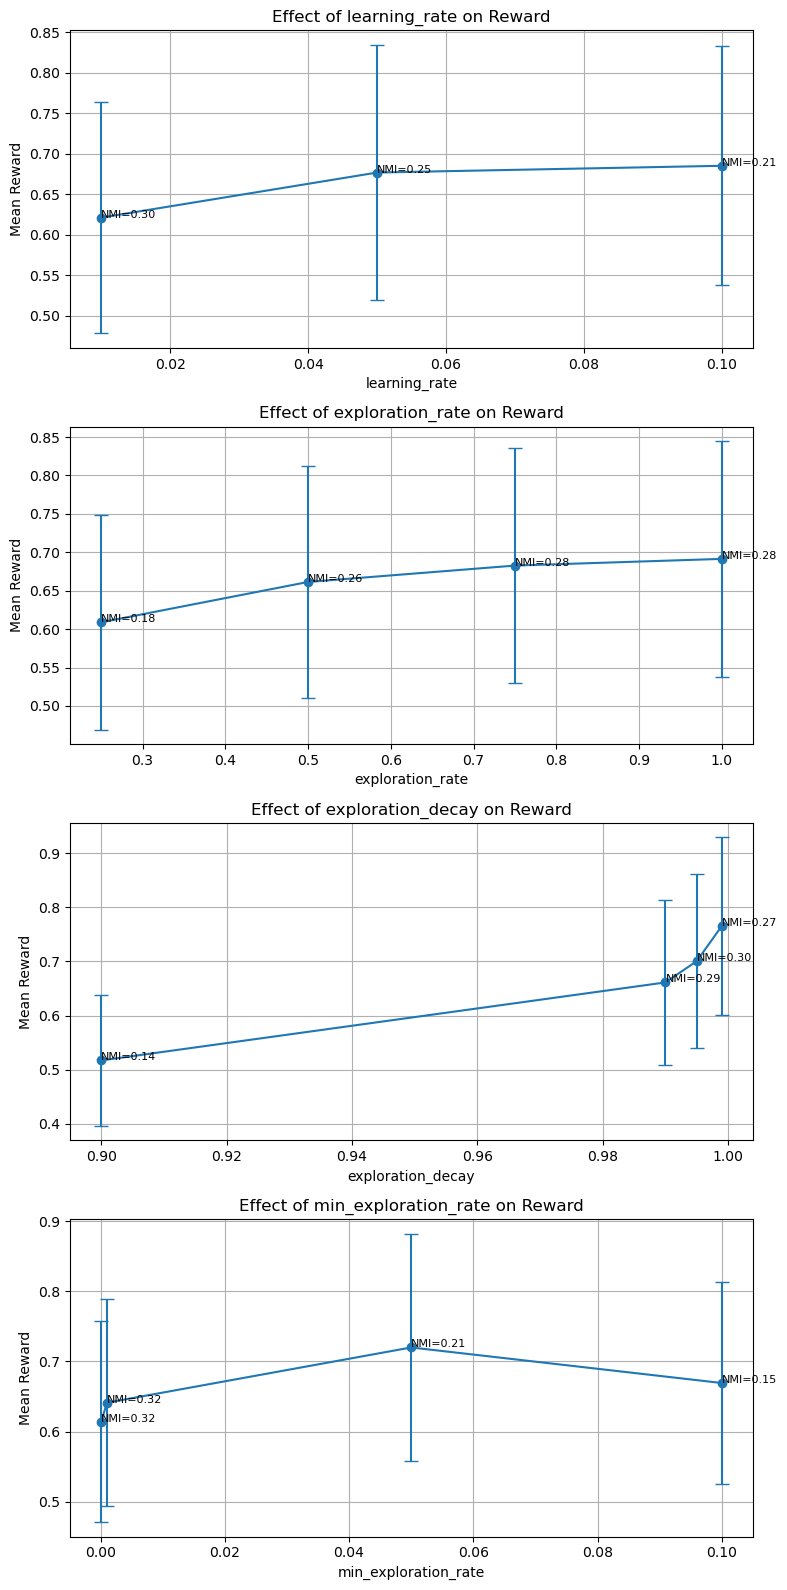

In [ ]:
full_df, top_configs = analyze_results(q_search_results, top_n=5)
top_k_df = full_df.sort_values(by='mean_reward', ascending=False).head(15)
plot_param_sensitivity(top_k_df)


# TD Agent

In [ ]:
def parameter_search(
    param_grid,
    n_trials=3,
    n_episodes=10000,
    base_seed=42
):
    results = []

    # Generate all combinations of hyperparameters
    keys = list(param_grid.keys())
    combos = list(itertools.product(*[param_grid[k] for k in keys]))

    for combo in combos:
        params = dict(zip(keys, combo))
        avg_rewards = []
        avg_final_nmi = []

        for trial in range(n_trials):
            seed = base_seed + trial
            np.random.seed(seed)

            # Setup graph
            G = nx.DiGraph()
            G.add_nodes_from([0, 1])
            G.add_edges_from([(0, 1), (1, 0)])

            # Setup game and env
            n_agents = 2
            n_features = 2
            n_signaling_actions = 2
            n_final_actions = 4
            agents_observed_variables = {0: [0], 1: [1]}
            game = {i: create_random_canonical_game(n_features, n_final_actions, n=1, m=0)
                    for i in range(n_agents)}

            env = TempNetMultiAgentEnv(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                full_information=False,
                game_dicts=game,
                observed_variables=agents_observed_variables,
                agent_type=TDLearningAgent,
                graph=G
            )

            # Override agents manually with hyperparameters
            env.agents = [
                TDLearningAgent(
                    n_actions=env.max_actions,
                    learning_rate=params['learning_rate'],
                    exploration_rate=params['exploration_rate'],
                    exploration_decay=params['exploration_decay'],
                    min_exploration_rate=params['min_exploration_rate']
                ) for _ in range(n_agents)
            ]

            _, rewards_history, signal_information_history, _, _ = temp_simulation_function(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                n_episodes=n_episodes,
                with_signals=True,
                plot=False,
                env=env,
                verbose=False
            )

            # Measure average reward in last 10% of episodes
            final_rewards = [
                np.mean(rewards[-n_episodes // 10:]) for rewards in rewards_history
            ]
            avg_rewards.append(np.mean(final_rewards))

            # Measure final normalized mutual information
            final_nmi = [
                np.mean(agent_nmi[-n_episodes // 10:]) if len(agent_nmi) >= n_episodes // 10 else 0.0
                for agent_nmi in signal_information_history
            ]
            avg_final_nmi.append(np.mean(final_nmi))

        result = {
            'params': params,
            'mean_reward': np.mean(avg_rewards),
            'std_reward': np.std(avg_rewards),
            'mean_final_nmi': np.mean(avg_final_nmi)
        }
        results.append(result)
        print(f"Tested: {params} => Mean Final Reward: {result['mean_reward']:.3f}, Mean Final NMI: {result['mean_final_nmi']:.3f}, Std Reward: {result['std_reward']:.3f}")

    return sorted(results, key=lambda r: -r['mean_reward'])


# Example usage
param_grid = {
    'learning_rate': [0.2,0.1, 0.01],
    'exploration_rate': [1.0, 0.75, 0.5,0.25],
    'exploration_decay': [0.999,0.995, 0.99, 0.9],
    'min_exploration_rate': [0.1,0.05,0.001, 0.0001]
}

td_search_results = parameter_search(param_grid, n_trials=100, n_episodes=5000)

for r in td_search_results:
    print(r)


Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.1} => Mean Final Reward: 0.686, Mean Final NMI: 0.061, Std Reward: 0.130
Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.05} => Mean Final Reward: 0.801, Mean Final NMI: 0.146, Std Reward: 0.158
Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.001} => Mean Final Reward: 0.956, Mean Final NMI: 0.355, Std Reward: 0.121
Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.999, 'min_exploration_rate': 0.0001} => Mean Final Reward: 0.926, Mean Final NMI: 0.330, Std Reward: 0.148
Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.995, 'min_exploration_rate': 0.1} => Mean Final Reward: 0.676, Mean Final NMI: 0.070, Std Reward: 0.124
Tested: {'learning_rate': 0.1, 'exploration_rate': 1.0, 'exploration_decay': 0.

🔝 Top 5 Configurations by mean_reward:

 learning_rate  exploration_rate  exploration_decay  min_exploration_rate  mean_reward  std_reward  mean_final_nmi
           0.1              1.00              0.999                0.0010      0.95570    0.120703        0.355145
           0.1              0.75              0.999                0.0010      0.94159    0.133772        0.394598
           0.1              0.50              0.999                0.0001      0.92954    0.144492        0.410751
           0.1              1.00              0.999                0.0001      0.92639    0.148423        0.329551
           0.1              0.75              0.999                0.0001      0.92466    0.143222        0.389357


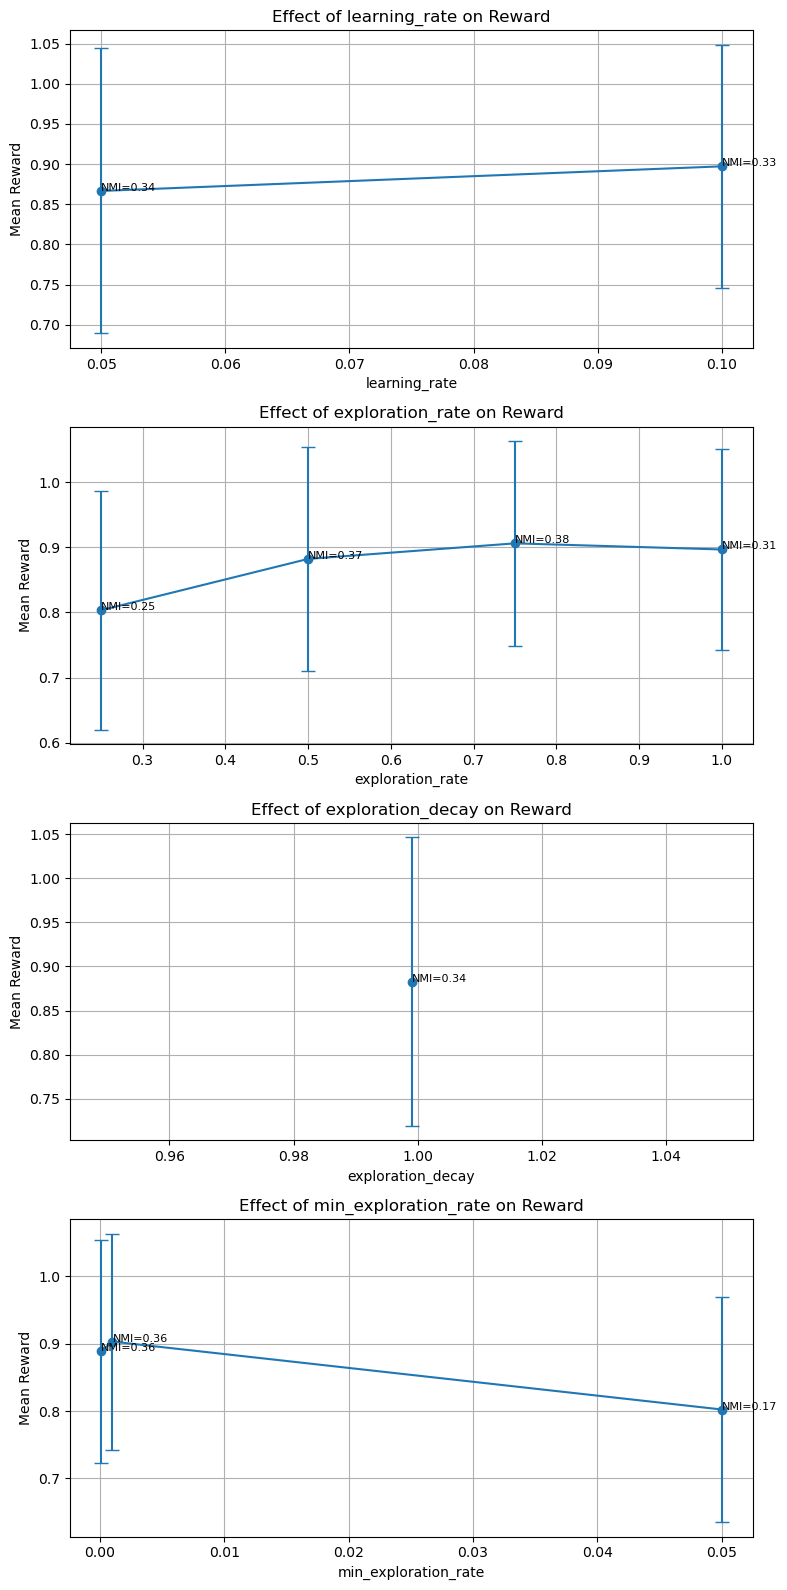

In [ ]:
full_df, top_configs = analyze_results(td_search_results, top_n=5)
top_k_df = full_df.sort_values(by='mean_reward', ascending=False).head(15)
plot_param_sensitivity(top_k_df)
